Initial version forked from SCTP-working(LGB) https://www.kaggle.com/dromosys/sctp-working-lgb courtesy of Dromosys

This kernel is intended to examine a statistical hypothesis about the population which contest entries sometimes assume but may not always test. 

This formal statistical testing may help you validate your contest winning straegy!

I noticed several entries in this contest look at the TRAINING set and count the percentage of targets being equal to "1," These entries go on to hypothesize that the percentage of targets equal to "1" in the TEST set is the same. By this hypothesis, the use of stratified k-fold segmentation, and other probability-assuming techniques are used. Are these techniques really justified, and how can we test this hypothesis?

Statistical analysis offers us a straightforward way to test this hypothesis, as follows:

* We begin with a Hypothesis H-0 and assume it is correct. We also identify the opposite (or alternate) hypothesis H-a.
* We then choose a level of significance we are targeting, alpha, which equals the probability that we find H-0 false when it really is true. Common values for alpha are 5%, 10%, or even as low as 1%. Note, this also provides us with a confidence level c = 1 - alpha
* Next, we take random samples (of sufficient size) from the population, and test if any of them prove that H-0 is false. We only expect that very few (alpha) will be statistically significant.
* Finally we will extend our findings to further useful statistical inferences about the data useful for this competition.

Note: we can never prove out hypothesis, we can only disprove it, or fail to disprove it!

In [1]:
# First some "import" housekeeping
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import os
import time
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
import math
from math import sqrt

In [2]:
# Here is the data 
print(os.listdir("../input"))
train_df = pd.read_csv('../input/train.csv')
print('Rows: ',train_df.shape[0],'Columns: ',train_df.shape[1])
train_df.info()

['test.csv', 'train.csv', 'sample_submission.csv']
Rows:  200000 Columns:  202
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


Here are the first few examples from the training set

In [3]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
# The usual split of the data into an X and a y array
X = train_df.drop(['ID_code','target'],axis=1)
y = train_df['target']

Here are the target value counts. It is from these target value counts that we will form our hypothesis. 

In statistics terminology, the Santander problem is a Bernoulli trial of the random variable X. 
* The probability of having a "1" for the target is p, and so the expected value of X is p, and the variance is p * (1 - p)
* if we take n samples from the Santander population, and we add up all the ones that had a target of "1", the total T will be a binomial distribution with an integer value anywhere from 0 to n.
* The binomial distribution is such that the probability of having k targets = 1 is P(T = k) = (n choose k) * p^k / (1 - p)^k
* This makes the expected value of T = np, the variance of T = n * p * (1 - p), and the standard deviation of T = sqrt(n * p * (1 - p)) or equivalently, (n * p * (1 - p)) ^ 0.5
* Since we cannot sample the entire Santander population, we can only make estimates. We can estimate p as a value we call p_hat
* Using the above sample from the population, p_hat is by definition T / n, so the variance of p_hat is p * (1 - p) / n, and the standard deviation (sometimes called standard error because we're only talking about a sample) is the square root of the variance.
* We fully expect that p_hat approahes p, as n approaches infinity.

**How confident are we ** in the use of p_hat (or "p from the training set") as the value p in our Bayes theorem, and therefore the use of "StratifiedKFold" etc.?

* First we see the **probability p that the target is "1"** in the training set as being simply the number of "1" targets divided by the whole set; where the probability of "not-p" is q = 1 - p.
* Then we calculate the **minimum number of samples** we need to take from the training set, such that within those samples, p-hat, the number of "1" targets, is approximately normally distributed. This is true if np ≥ 5 and nq ≥ 5; where n is the number of items in our samples.
* If the above is true, and we take repeated n samples from the training set, then the mean value of p_hat for those samples will be mu(p_hat) = p, and the standard deviation sigma(p_hat) = ( (p * q) / n ) ^ 0.5
* We can create what is called a "two-tailed" hypothesis stating that 95% of p_hat values will fall within the range of p plus or minus 1.96 sigma(p)

* We can then find confidence intervals, after we shift and stretch the distribution until it has a standard normal distribution (mean = 0, standard deviation = 1), by using Z-Tables for the standard normal distribution


target value counts 
0    179902
1     20098
Name: target, dtype: int64
Probability p of target being 1:  0.10049
Probability q of target being 0:  0.89951
Minimum number of samples of test set for an approximately normal distribution is:  50
Expected standard deviation if minimum number of samples taken  0.0006722788108366944


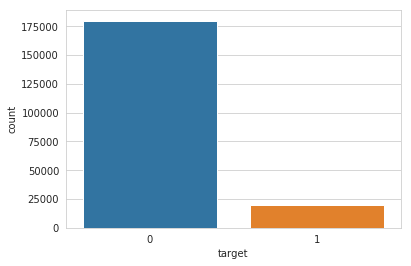

In [5]:
split = train_df['target'].value_counts()
print("target value counts ")
print( split)
tot = split[0] + split[1]
p = split[1]/(split[0] + split[1])
q = 1 - p
sigma = sqrt((p * q) / tot)
# If np ≥ 5 and nq ≥ 5 for a binomial distribution, then the sampling can have distribution for p-hat that is approximately normal
# and since p is smaller than q, we have
min_sample = int((5 / p)+1)
print("Probability p of target being 1: ", p )
print("Probability q of target being 0: ", q )
print("Minimum number of samples of test set for an approximately normal distribution is: ", min_sample )
print('Expected standard deviation if minimum number of samples taken ', sigma)
sns.countplot(train_df['target'])
sns.set_style('whitegrid')

So what this means is that if we take a sample of data from our training set, and calculate the p-hat in that sample, over time, it should form a normal distribution with a mean of p, and a standard deviation of sigma. 

* With 200,000 samples in our training set, we can perform at most 4,000 tests since each test must contain 50 samples.
* Let's try that with 50 tests (folds) taking 4000 random samples each.
* NOTE: we are not using "StratifiedKFold" and instead we use simply "KFold"  because we purposely do not want to assume the probability "P_hat"

Mean of distribution  0.10049 as compared to the predicted  0.10049
Standard Deviation of distribution 0.005001989604147533 as compared to the predicted   0.0006722788108366944


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


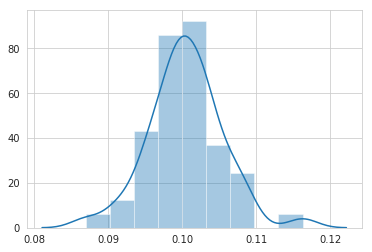

In [6]:
n_fold = 50 # number of sets of samples to randomly take from the training set
n = tot / n_fold
all_p_hats = np.zeros(n_fold)
all_std_errors = np.zeros(n_fold)

folds = KFold(n_splits=n_fold, shuffle=True, random_state = 12345)
for fold_n, (remainder, this_fold) in enumerate(folds.split(X,y)):
    y_this_fold = y.iloc[this_fold]
    n = y_this_fold.count()
    p_hat = y_this_fold.sum() / n
    std_error = sqrt((p_hat * (1 - p_hat)) / n)
#    print("Fold k = ", fold_n, "has a probability p of target being 1: ", p_hat  )
    all_p_hats[fold_n] = p_hat
    all_std_errors[fold_n] = std_error
        
print('Mean of distribution ', all_p_hats.mean(), 'as compared to the predicted ', p)
print('Standard Deviation of distribution', all_p_hats.std(), 'as compared to the predicted  ', sigma)
# Use Freedman–Diaconis rule to pick a good number of bins 
bin_width = 2.0 * ((np.percentile(all_p_hats, q=75) - np.percentile(all_p_hats, q=25)) / np.cbrt(n_fold))
bins = int ( (all_p_hats.max() - all_p_hats.min() ) / bin_width )
sns.distplot(all_p_hats, bins=bins)

You can try different values for "n_fold" and thereby change the number of experiments, but be sure not to exceed 4,000 because then our assumptions of approximate normal distribution are violated.

So from the above, it looks like the mean is spot-on, whereas the standard deviation is a bit bigger than expected (a bit wide). What does this mean to our hypothesis?

In order to formally test a hypothesis, we need to formally state the hypothesis.
* H-0, our null hypothesis, states that the probability of the target being equal to "1" in the population is p = 10.049 %
* We choose a level of significance alpha such as 5%, which would equivalently give us a confidence level c = 95%
* We repeat our tests (as per the above) and test if any of them prove that H-0 is false. We only expect that very few (alpha) will be statistically significant.

First, shift and squeeze the distribution to be "standard" (zero mean, variance = 1) normal distribution, this will give us a "Z-value" for each of our samples (folds).
* The graph should look roughly the same, just shifted and squeezed.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


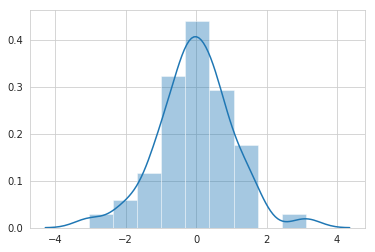

In [7]:
all_zs = np.zeros(n_fold)
for j in range (n_fold) :
    p_hat = all_p_hats[j]
    std_error = all_std_errors[j]
    z = (p_hat - p) / std_error
#    print("Fold k = ", j, "has a z value of ", z  )
    all_zs[j] = z
bin_width = 2.0 * ((np.percentile(all_zs, q=75) - np.percentile(all_zs, q=25)) / np.cbrt(n_fold))
bins = int ( (all_zs.max() - all_zs.min() ) / bin_width )
sns.distplot(all_zs, bins=bins)

Beside a hypothesis null and alternate values, we also have to have a "significance"
* If we choose a level of significance alpha such as 5%, it would equivalently give us a confidence level c = 95%
* We now examine our z values again, except we are now comparing them to the rejection regions, otherwise known as the Z-test

For each alpha, count how many z values exceed the + or - z0 rejection regions for our given confidence level.

In [8]:
# Choose a few Alphas
alphas = (.5, .4, .2, 0.1, 0.05, 0.01, 0.001, 0.0001)
z0s = (.675, .84, 1.28, 1.645, 1.960, 2.576, 3.290, 3.891)
num_alphas = len(alphas)
rej_count = np.zeros(num_alphas, dtype = int)
expected_rej_count = np.zeros(num_alphas)
for j in range(num_alphas) :
    expected_rej_count[j] = int(alphas[j] * n_fold)

for i in range (n_fold):
    this_z = all_zs[i]
    for j in range(num_alphas) :
        alpha = alphas[j]
        z0 = z0s[j] 
        if this_z > z0 :
            rej_count[j] += 1
        if this_z < -z0 :
            rej_count[j] += 1

print ("Alpha values we will test")
print(alphas)
print ("Expected number (alpha pecent out of ",n_fold,") that will fail the z-test")
print(expected_rej_count)
print ("Actual number that failed the z-test")
print(rej_count)
print("Confidence level = 1 - Alpha")
for j in range(num_alphas) :
    if (expected_rej_count[j] < rej_count[j]) :
        print ("For confidence level of", ((1 - alphas[j])*100), "percent, the hypothesis is proven FALSE")
    else : 
        print ("For confidence level of", ((1 - alphas[j])*100), "percent, the hypothesis may still be true")


Alpha values we will test
(0.5, 0.4, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001)
Expected number (alpha pecent out of  50 ) that will fail the z-test
[25. 20. 10.  5.  2.  0.  0.  0.]
Actual number that failed the z-test
[23 18 10  5  4  2  0  0]
Confidence level = 1 - Alpha
For confidence level of 50.0 percent, the hypothesis may still be true
For confidence level of 60.0 percent, the hypothesis may still be true
For confidence level of 80.0 percent, the hypothesis may still be true
For confidence level of 90.0 percent, the hypothesis may still be true
For confidence level of 95.0 percent, the hypothesis is proven FALSE
For confidence level of 99.0 percent, the hypothesis is proven FALSE
For confidence level of 99.9 percent, the hypothesis may still be true
For confidence level of 99.99 percent, the hypothesis may still be true


CONCLUSION:
* Whenever the hypothesis is proven FALSE for a particular confidence level, we can no longer have that level of confidence that p and sigma will hold true for the population if p-hat and standard error are measured for a sample from that population. 
* If we prove our hypothesis FALSE at a certain confidence level, but it may still be true at GREATER confidence levels, then we might want to attribute that to the random nature of the selection (and may want to run more tests) - but in either case, we would stick with the HIGHEST CONFIDENCE LEVEL LOWER THAN A PROVEN FALSE LEVEL.

NEXT STEPS:
* Try additional numbers of folds, and/or different random selection menthods (remember, using the above K-folkds still makes sure every training sample is selected once and only once - rather than re-scrambling every fold)
* Once you have a good feel for your best confidence level, re-examine assumptions.

ASSUMPTIONS TO RE-EXAMINE:
* StratifiedKFold is teaching the classification algorithm an assumed value of p with a high confidence level, but is that a good assumption?
* Alternatively, randomly selecting from the training set (KFold) let's the p_hat dominate the training for that fold, which varies as we can see above.
* Finally, we may choose a different training / validation split methodology altogether. For example...
* How close are the training set samples to the test set samples (classification notwithstanding)? 
* Perhaps an adversarial validation scheme is warranted.

I hope this was helpful to you!